# Quantum error correction (basic example) - 3-qubit repetition code
A simple repetition code based on paper by Asher Peres: [Reversible logic and quantum computers](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.32.3266)

In [ ]:
! pip install pylatexenc
! pip install qiskit

In [54]:
# initialization
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

# import basic plot tools
from qiskit.visualization import plot_histogram

n = 5

In [55]:
def encode(circuit,logicalQubit, dup1, dup2):
    circuit.cnot(logicalQubit,dup1)
    circuit.cnot(logicalQubit,dup2)
    circuit.barrier()

# A naive, un-optimized, working implementation:
def error_syndrome(circuit,q0,q1,q2,ancilla1,ancilla2):
    circuit.barrier()
    # Set ancilla s1 to equal 1 iff q0!=q1
    circuit.cnot(q0,ancilla1)
    circuit.cnot(q1,ancilla1)
    # Set ancilla s2 to equal 1 iff q1!=q2
    circuit.cnot(q1,ancilla2)
    circuit.cnot(q2,ancilla2)
    circuit.barrier()

    # flip q0 if s1==1
    circuit.cnot(ancilla1,q0)
    # flip q2 if s2==1
    circuit.cnot(ancilla2,q2)

    # flip all if s1=s2=1 (basically reverses previous flips and flips q1)
    circuit.toffoli(ancilla1,ancilla2,q0)
    circuit.toffoli(ancilla1,ancilla2,q1)
    circuit.toffoli(ancilla1,ancilla2,q2)

def decode(circuit,logicalQubit, dup1, dup2):
    circuit.barrier()
    circuit.cnot(logicalQubit,dup2)
    circuit.cnot(logicalQubit,dup1)

# A better, optimized implementation.
# Note: this should be used instead of both decode AND error_syndrome functions!
def decode_optimize(circuit, logicalQubit, dup1, dup2):
    circuit.barrier()
    circuit.cnot(logicalQubit,dup1)
    circuit.cnot(logicalQubit,dup2)
    circuit.toffoli(dup1,dup2,logicalQubit)

In [58]:
def generateCircuit(applyErrorCorrection = False, optimizedEC = True, mainCircuitLengthMultiple = 1):
    qreg_q = QuantumRegister(n, 'q')
    creg_c = ClassicalRegister(n, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    if applyErrorCorrection:
        encode(circuit,0,1,2)

    # main circuit: should end where it started.
    for i in range(0,mainCircuitLengthMultiple):
        circuit.h(0)
        circuit.t(0)
        circuit.t(0)
        circuit.t(0)
        circuit.t(0)
        circuit.t(0)
        circuit.t(0)
        circuit.t(0)
        circuit.t(0)
        circuit.h(0)

    # simulate error (not needed in real HW since we have noise there already:
    # circuit.x(0)

    if applyErrorCorrection:
        if optimizedEC:
            decode_optimize(circuit,0,1,2)
        else:
            error_syndrome(circuit,0,1,2,3,4)
            decode(circuit,0,1,2)

    circuit.measure(qreg_q[0],creg_c[0])

    circuit.draw('mpl')
    return circuit

In [75]:
circuits = []
for i in range(1,5):
    circuitTemp = generateCircuit(False, False, i)
    circuits.append(circuitTemp)
    circuitTemp = generateCircuit(True, False, i)
    circuits.append(circuitTemp)
    circuitTemp = generateCircuit(True, True, i)
    circuits.append(circuitTemp)

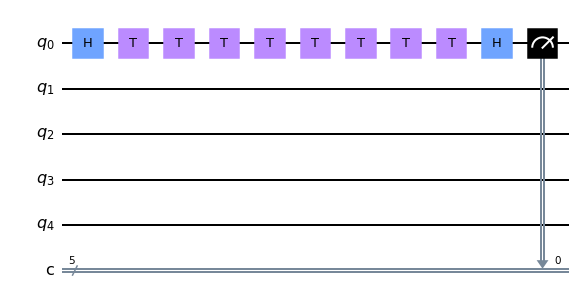

In [76]:
circuits[0].draw('mpl')

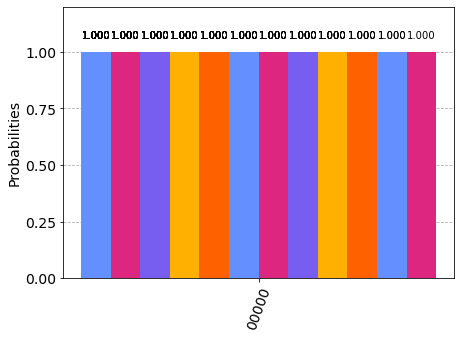

In [77]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
# shots = 1000000 # max shots
results = aer_sim.run(circuits, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n) and
                                                         not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 20000
transpiled_circuits = transpile(circuits, backend, optimization_level=0)
job = backend.run(transpiled_circuits)
job_monitor(job, interval=2)